## Example with CNN-LSTM on live BTC close price using the full data

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [ ]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169728, 8)


### Generate Candles and build features from technical analysis

In [ ]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [ ]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime("220625_20_46", '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

In [ ]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

9

,Close,Pred Close
Date,,
2021-01-20 23:16:00,35646.63,35232.066846
2021-01-20 23:31:00,35602.83,35225.700406
2021-01-20 23:46:00,35468.23,35165.940977
2021-01-21 00:01:00,35328.41,35180.454495
2021-01-21 00:16:00,35302.32,35191.959912
...,...,...
2022-06-25 22:01:00,21431.71,21380.903523
2022-06-25 22:16:00,21434.87,21406.683513
2022-06-25 22:31:00,21452.89,21408.647453


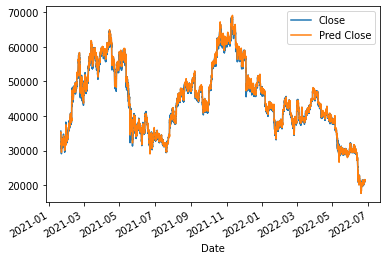

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

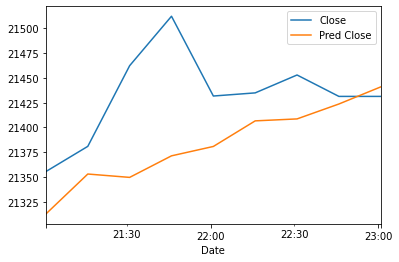

In [ ]:
df_preds_true.dropna().iloc[-new_time_steps:].plot()

Fee: 0.025
----------------------
Buy      210 ( 125 ok 85 ko )
Avg PCT gain: 1.0060192154178553
Avg PCT loss: 0.9953012708435273
Wins  PCT   0.5952380952380952
Avg PCT Gain.    1.0060192154178553
No-op    0
Wallet   6390.506749999999
Drawback -713.5024999999986
Kelly Fraction    0.1947884497199025
Total earned 6390.506749999999


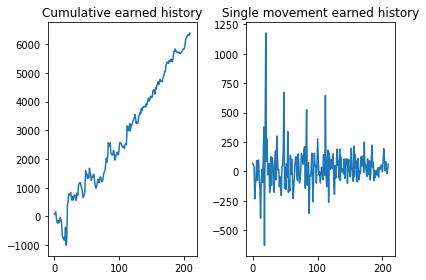

In [ ]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna().iloc[-1000:], ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)